In [1]:
import os
import sys
import json
import random
import collections
import numpy as np
from scipy import io as sio
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.append('C:\\Users\\Dell\\Desktop\\CV Projects\\ecg')

import load

import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
base_dir = 'C:\\Users\\Dell\\Desktop\\CV Projects\\ecg'
data_json = os.path.join(base_dir, 'data/train.json')

In [3]:
def rythyms_per_patient(data_json):
    """
    Returns the number of patients that falls under each rythym.
    
    NB: Rythym here corresponds to the four classes: normal sinus rythym (N), atrial fibrillation (A), 
        other rythym (O), and noise (~).
    """
    # Create a set dictionary to accomodate each rythym alongside the ids of the patients that fall
    # under them
    rythyms_with_corresponding_patients = collections.defaultdict(set)
    with open(data_json, 'r') as file:
        data = [json.loads(l) for l in file]
        
    for datum in data:
        patient_id = os.path.basename(datum['ecg']).split('_')[0].split('.')[0]
        for label in datum['labels']:
            rythyms_with_corresponding_patients[label].add(patient_id)
            
    rythyms = sorted(rythyms_with_corresponding_patients.keys())
    
    return rythyms, rythyms_with_corresponding_patients

In [4]:
STEP = 256

In [5]:
def get_sample(rythyms, rythyms_with_corresponding_patients):
    """Picks one patient from each class randomly."""
    rythym_pid = [{rythym : random.choice(list(rythyms_with_corresponding_patients[rythym]))} for rythym in rythyms]
    return rythym_pid


def load_ecg(record):
    """Loads an ECG record"""
    if os.path.splitext(record)[1] == ".npy":
        ecg = np.load(record)
    elif os.path.splitext(record)[1] == ".mat":
        # If record is in matlab format
        ecg = sio.loadmat(record)['val'].squeeze()
    else: 
        # Assumes binary 16 bit integers
        with open(record, 'r') as file:
            ecg = np.fromfile(file, dtype=np.int16)
            
    # Truncate the ecg record
    trunc_samp = STEP * int(len(ecg) // STEP)
    return ecg[:trunc_samp]


def compute_mean_std(x):
    return (np.mean(x).astype(np.float32),
           np.std(x).astype(np.float32))

def normalize(x):
    mean, std = compute_mean_std(x)
    x = (x - mean) / std
    return x


def class_full_name(cname):
    if cname == 'A':
        return 'Atrial Fibrillation'
    elif cname == 'N':
        return 'Normal Sinus Rythym'
    elif cname == 'O':
        return 'Other Rythym'
    elif cname == '~':
        return 'Noise'

In [6]:
rythyms, rythyms_with_corresponding_patients = rythyms_per_patient(data_json)

In [7]:
def plot_ecg(sequence_length, sampling_frequency, file_name):
    f, ax = plt.subplots(2, 2, figsize=(20 ,10))
    f.suptitle('Electrocardiogram',fontsize=20)
    time = np.arange(0, sequence_length)/sampling_frequency
    color = ['red', 'blue', 'green', 'purple']
    x = 0
    for n in range(2):
        for m in range(2):
            sample = get_sample(rythyms, rythyms_with_corresponding_patients)[x]
            rythym, pid = list(sample.keys())[0], list(sample.values())[0]
            ecg = load_ecg(os.path.join(base_dir, 'data/training2017', pid)+'.mat')
            ecg = normalize(ecg)
            sns.lineplot(x=time, y=ecg[:sequence_length], ax=ax[n, m], color=color[x])
            ax[n,m].set_title('{} (Patient ID: {})'.format(class_full_name(rythym), pid), size=16)
            ax[n,m].set_xlabel('Time (secs)', size=14)
            ax[n,m].set_ylabel('Electric Potential (mV)', size=14)
            ax[n,m].set_xlim(0, sequence_length/sampling_frequency)
            #ax[i].set_ylim()
            x += 1
    f.tight_layout(rect=[0, 0.03, 1, 0.9])
    
    plt.savefig(file_name,
       dpi=400,
       format='png',
       bbox_inches='tight')

In [8]:
sequence_length = 1500
sampling_frequency = 300
file_name = os.path.join(base_dir, 'ecg_plots.png')

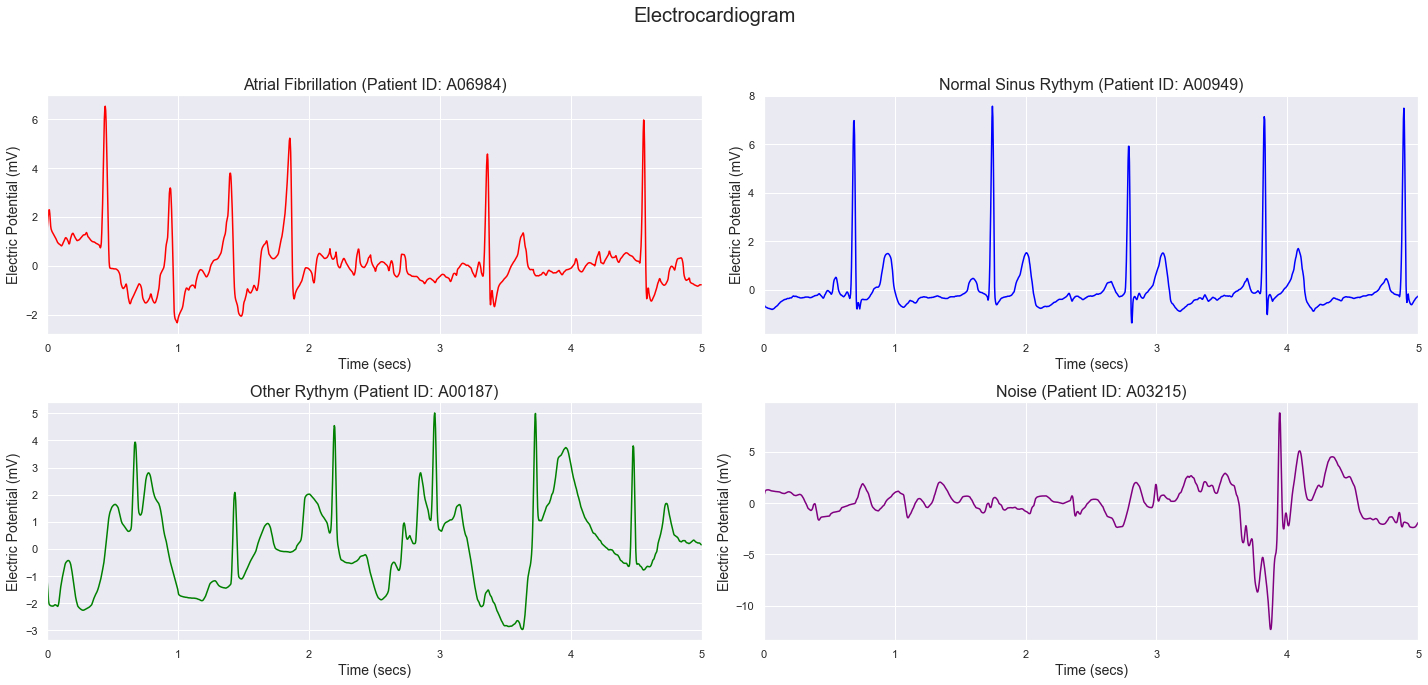

In [9]:
plot_ecg(sequence_length, sampling_frequency, file_name)